In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

In [269]:
df = pd.read_csv("../data/ltv_cleaned_data.csv", index_col=0)

df[["event_timestamp", "first_purchase_time", "cohort_week"]] = df[
    ["event_timestamp", "first_purchase_time", "cohort_week"]
].apply(pd.to_datetime)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200 entries, 0 to 1199
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   user_id                   1200 non-null   object        
 1   event_timestamp           1200 non-null   datetime64[ns]
 2   first_purchase_time       1200 non-null   datetime64[ns]
 3   cohort_week               1200 non-null   datetime64[ns]
 4   product_id                1200 non-null   object        
 5   lifetime_months           1200 non-null   int64         
 6   max_possible_lifetime     1200 non-null   int64         
 7   adjusted_lifetime_months  1200 non-null   int64         
dtypes: datetime64[ns](3), int64(3), object(2)
memory usage: 84.4+ KB


In [270]:
# df = df[df["lifetime_months"] < 6]

# df.describe()

In [271]:
import re

price = df["product_id"].apply(
    lambda x: (
        float(re.search(r"\d+\.\d+", x).group()) if re.search(r"\d+\.\d+", x) else 0
    )
)
price = price.unique()[0]

# Calculate total revenue (LTV) for each user
df["price"] = price

user_revenue = df.groupby("user_id")["price"].sum()

df["revenue"] = df["user_id"].map(user_revenue)

# Find the maximum lifetime value (in months) for each user
# Assuming one purchase per month, the number of purchases would represent the number of months
user_lifetime = df.groupby("user_id").size()

# Create a new DataFrame with user_id, LTV, and lifetime value
ltv_df = pd.DataFrame(
    {
        "user_id": user_revenue.index,
        "revenue": user_revenue.values,
        "lifetime_months": user_lifetime.values,
        "cohort_week": user_lifetime.values,
    }
)

cohort_week_series = df.drop_duplicates(subset=["user_id"]).set_index("user_id")[
    "cohort_week"
]
ltv_df["cohort_week"] = ltv_df["user_id"].map(cohort_week_series)


test_user = ltv_df[ltv_df["user_id"] == "95287b91-85af-4174-9986-aeafb3853bb6"]
(test_user["revenue"] / test_user["lifetime_months"] == price) & (
    test_user["cohort_week"] == pd.to_datetime("2023-03-19")
)

ltv_df.describe()

,revenue,lifetime_months,cohort_week
count,561.000000,561.000000,561
mean,26.716578,2.139037,2023-03-31 03:22:46.844919808
min,12.490000,1.000000,2023-03-05 00:00:00
25%,12.490000,1.000000,2023-03-12 00:00:00
50%,12.490000,1.000000,2023-03-26 00:00:00
75%,37.470000,3.000000,2023-04-16 00:00:00
max,99.920000,8.000000,2023-04-30 00:00:00
std,23.373535,1.871380,NaN


In [273]:
purchase_frequency = df.groupby("user_id").size().rename("purchase_frequency")
ltv = ltv_df.groupby("user_id")["revenue"].sum()
ltv_frequency_df = pd.concat(
    [purchase_frequency, ltv, ltv_df.groupby("user_id")["lifetime_months"].sum()],
    axis=1,
)

(ltv_frequency_df["purchase_frequency"] == ltv_frequency_df["lifetime_months"]).unique()

ltv_frequency_df

,purchase_frequency,revenue,lifetime_months
user_id,,,
0047993c-3cff-4ab4-a34a-e376f823c282,1,12.49,1
00f7a8b6-9dd5-4806-bc31-69c8bc68bb24,1,12.49,1
0124f243-d4d0-4971-b997-1e6b79c866f0,2,24.98,2
0126e40c-da09-4e28-b687-457716e6ccfd,1,12.49,1
027c73fe-ac43-4ce4-820d-05a927342c7e,2,24.98,2
...,...,...,...
fe7ab67d-d268-4775-8ba8-f2ffb42a9b2e,2,24.98,2
feb2ebc8-fbd7-46a1-bb66-faab175495c7,1,12.49,1
fec8b6a1-1bfc-49af-bc87-69679149945f,1,12.49,1


In [274]:
ltv_df["lifetime_months"].describe()

count    561.000000
mean       2.139037
std        1.871380
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max        8.000000
Name: lifetime_months, dtype: float64

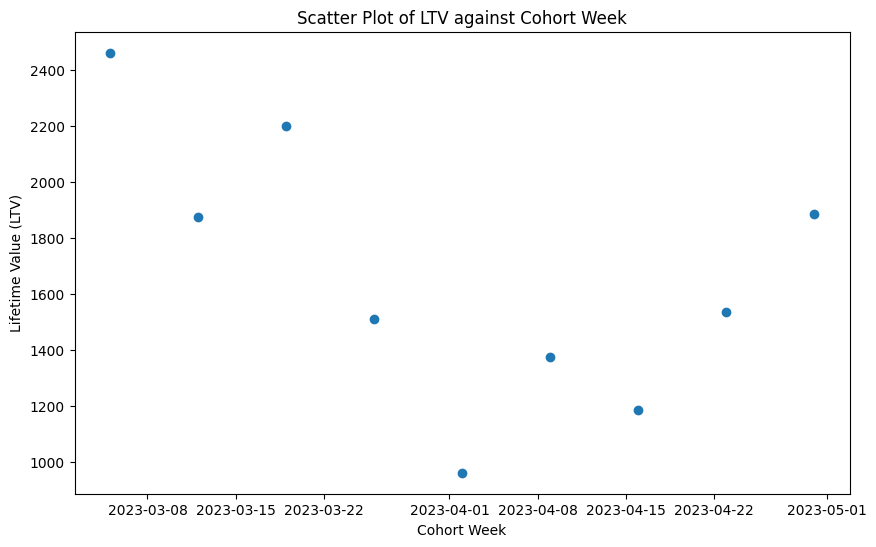

In [275]:
cohort_revenue_df = ltv_df.groupby("cohort_week")["revenue"].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.scatter(cohort_revenue_df["cohort_week"], cohort_revenue_df["revenue"])
plt.title("Scatter Plot of LTV against Cohort Week")
plt.xlabel("Cohort Week")
plt.ylabel("Lifetime Value (LTV)")
plt.show()

## Prepare df to model creation

In [276]:
ltv_prediction_df = df[["user_id", "event_timestamp", "revenue", "cohort_week"]]

observation_period_end = str(ltv_prediction_df["event_timestamp"].max().date())

ltv_prediction_df["revenue"].max()

ltv_prediction_df.describe()

observation_period_end

'2023-10-14'

In [277]:
cohort_metrics = (
    ltv_prediction_df.groupby("cohort_week")
    .agg(
        total_purchases=("event_timestamp", "count"),
        total_revenue=("revenue", "sum"),
        avg_revenue=("revenue", "mean"),
    )
    .reset_index()
)

cohort_metrics

,cohort_week,total_purchases,total_revenue,avg_revenue
0,2023-03-05,197,10229.31,51.925431
1,2023-03-12,150,7668.86,51.125733
2,2023-03-19,176,8493.20,48.256818
3,2023-03-26,121,5907.77,48.824545
4,2023-04-02,77,3484.71,45.255974
5,2023-04-09,110,6369.90,57.908182
6,2023-04-16,95,3409.77,35.892316
7,2023-04-23,123,4483.91,36.454553
8,2023-04-30,151,6507.29,43.094636


In [278]:
from lifetimes.utils import summary_data_from_transaction_data

# monetary_value == revenue
summary__cohort_df = summary_data_from_transaction_data(
    ltv_prediction_df,
    "cohort_week",
    "event_timestamp",
    observation_period_end=observation_period_end,
)
summary__cohort_df = summary__cohort_df.merge(cohort_metrics, on="cohort_week")

summary__cohort_df

,cohort_week,frequency,recency,T,total_purchases,total_revenue,avg_revenue
0,2023-03-05,42.0,216.0,222.0,197,10229.31,51.925431
1,2023-03-12,44.0,212.0,215.0,150,7668.86,51.125733
2,2023-03-19,46.0,186.0,208.0,176,8493.20,48.256818
3,2023-03-26,37.0,186.0,201.0,121,5907.77,48.824545
4,2023-04-02,28.0,186.0,194.0,77,3484.71,45.255974
5,2023-04-09,35.0,184.0,187.0,110,6369.90,57.908182
6,2023-04-16,31.0,180.0,180.0,95,3409.77,35.892316
7,2023-04-23,32.0,155.0,173.0,123,4483.91,36.454553
8,2023-04-30,25.0,154.0,166.0,151,6507.29,43.094636


In [300]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.03)
bgf.fit(
    summary__cohort_df["frequency"],
    summary__cohort_df["recency"],
    summary__cohort_df["T"],
)

<lifetimes.BetaGeoFitter: fitted with 9 subjects, a: 0.00, alpha: 15.40, b: 0.00, r: 2.80>

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

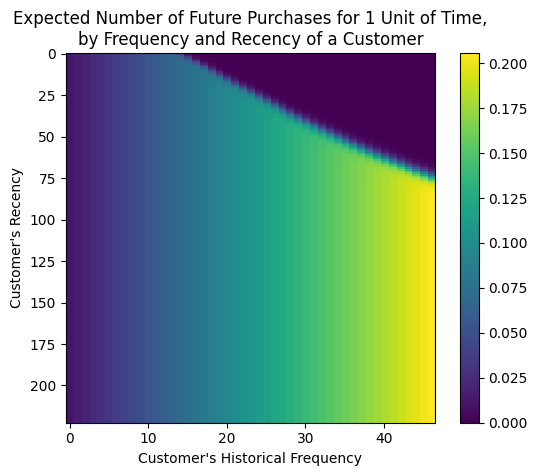

In [301]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

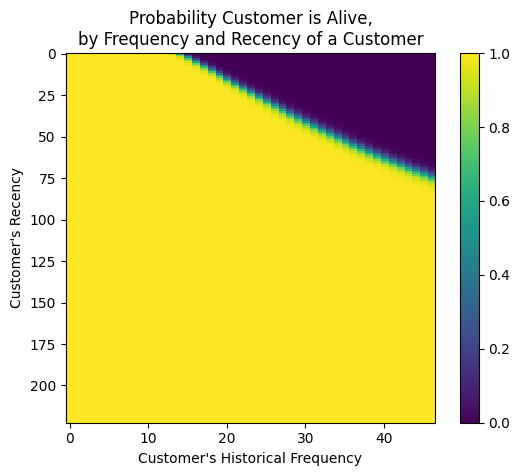

In [302]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

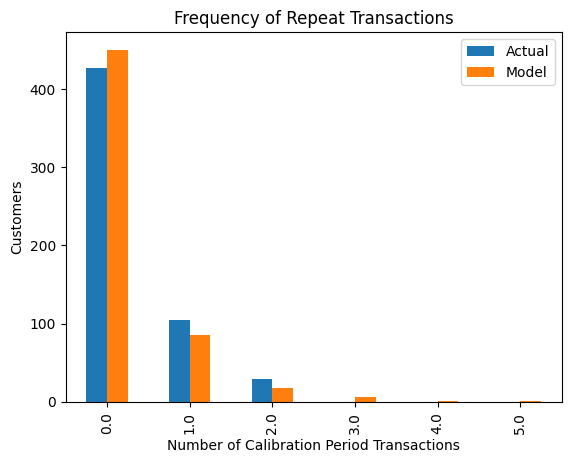

In [289]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf)

In [158]:
t = 1
summary__cohort_df["predicted_purchases"] = (
    bgf.conditional_expected_number_of_purchases_up_to_time(
        t,
        summary__cohort_df["frequency"],
        summary__cohort_df["recency"],
        summary__cohort_df["T"],
    )
)
summary__cohort_df.sort_values(by="predicted_purchases").tail(5)

,cohort_week,frequency,recency,T,total_purchases,total_revenue,avg_revenue,predicted_purchases
5,2023-04-09,35.0,184.0,187.0,110,6369.90,57.908182,0.135476
3,2023-03-26,37.0,186.0,201.0,121,5907.77,48.824545,0.135758
0,2023-03-05,42.0,216.0,222.0,197,10229.31,51.925431,0.142945
1,2023-03-12,44.0,212.0,215.0,150,7668.86,51.125733,0.153127
2,2023-03-19,46.0,186.0,208.0,176,8493.20,48.256818,0.163283


In [210]:
from lifetimes.utils import summary_data_from_transaction_data


# monetary_value == revenue
summary_df = summary_data_from_transaction_data(
    ltv_prediction_df,
    "user_id",
    "event_timestamp",
    observation_period_end=observation_period_end,
)
summary_df = summary_df.merge(ltv_prediction_df, on="user_id")

summary_df.head()

,user_id,frequency,recency,T,event_timestamp,revenue,cohort_week
0,0047993c-3cff-4ab4-a34a-e376f823c282,0.0,0.0,206.0,2023-03-22 06:02:55,12.49,2023-03-19
1,00f7a8b6-9dd5-4806-bc31-69c8bc68bb24,0.0,0.0,180.0,2023-04-17 10:19:29,12.49,2023-04-16
2,0124f243-d4d0-4971-b997-1e6b79c866f0,1.0,30.0,181.0,2023-04-16 15:14:30,24.98,2023-04-09
3,0124f243-d4d0-4971-b997-1e6b79c866f0,1.0,30.0,181.0,2023-05-16 15:14:30,24.98,2023-04-09
4,0126e40c-da09-4e28-b687-457716e6ccfd,0.0,0.0,219.0,2023-03-09 16:54:50,12.49,2023-03-05


In [291]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(summary_df["frequency"], summary_df["recency"], summary_df["T"])

<lifetimes.BetaGeoFitter: fitted with 1200 subjects, a: 0.00, alpha: 79.96, b: 0.14, r: 1.17>

In [56]:
from lifetimes import GammaGammaFitter

returning = summary_df[summary_df["frequency"] > 0]

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(returning["frequency"], returning["revenue"])  # monerary_value

<lifetimes.GammaGammaFitter: fitted with 853 subjects, p: 4.35, q: 0.72, v: 4.20>

In [61]:
from lifetimes.utils import _customer_lifetime_value

_customer_lifetime_value(
    bgf,
    summary_df["frequency"],
    summary_df["recency"],
    summary_df["T"],
    summary_df["revenue"],  # monetary_value
    time=14,
    discount_rate=0.1,
    freq="M",
).to_frame()

,clv
0,0.377090
1,0.414767
2,1.324958
3,1.324958
4,0.360707
...,...
1195,15.852831
1196,15.852831
1197,15.852831
1198,15.852831


In [304]:
from datetime import timedelta, datetime

summary_df["prediction_period"] = summary_df["event_timestamp"].min() + timedelta(
    days=365
)

# prediction_period = summary_df.drop(columns=["prediction_period"])
summary_df["rest"] = (
    summary_df["prediction_period"] - summary_df["event_timestamp"]
).dt.days / 30.44

summary_df.describe()

,frequency,recency,T,event_timestamp,revenue,cohort_week,prediction_period,rest
count,1200.000000,1200.000000,1200.000000,1200,1200.000000,1200,1200,1200.000000
mean,2.773333,85.975000,193.472500,2023-05-16 22:08:55.034166528,47.128933,2023-03-30 10:40:48,2024-03-05 04:55:29.999999744,9.614652
min,0.000000,0.000000,160.000000,2023-03-06 04:55:30,12.490000,2023-03-05 00:00:00,2024-03-05 04:55:30,4.664915
25%,0.000000,0.000000,175.000000,2023-04-05 11:13:16.500000,12.490000,2023-03-12 00:00:00,2024-03-05 04:55:30,8.541393
50%,3.000000,90.000000,197.000000,2023-05-02 05:23:36.500000,49.960000,2023-03-26 00:00:00,2024-03-05 04:55:30,10.101840
75%,5.000000,150.000000,211.000000,2023-06-18 15:04:00.249999872,74.940000,2023-04-16 00:00:00,2024-03-05 04:55:30,10.972405
max,7.000000,210.000000,222.000000,2023-10-14 06:00:06,99.920000,2023-04-30 00:00:00,2024-03-05 04:55:30,11.990802
std,2.411805,73.112953,19.628176,NaN,30.123443,NaN,NaN,1.816594


In [107]:
def equity(row):
    rest = row["rest"].values[0]
    return _customer_lifetime_value(
        bgf,
        summary_df["frequency"],
        summary_df["recency"],
        summary_df["T"],
        summary_df["revenue"],  # monetary_value
        time=14,
        discount_rate=0.1,
        freq="M",
    )


def e_purchases(row, bgf):
    return bgf.conditional_expected_number_of_purchases_up_to_time(
        row["rest"],  # period for which customer that we want to predict future value
        row["frequency"],
        row["recency"],
        row["T"],
    )


summary_df["equity"] = 0
for i, row in summary_df.iterrows():
    summary_df.at[i, "equity"] = equity(row.to_frame().T).values[0]

In [108]:
summary_df["clv"] = summary_df["revenue"] + summary_df["equity"]
summary_df["purchases"] = summary_df.apply(
    lambda row: e_purchases(row, bgf) + row["frequency"] + 1, axis=1
)

In [123]:
summary_df.describe()

,frequency,recency,T,event_timestamp,revenue,equity,prediction_period,rest,clv,purchases
count,1200.000000,1200.000000,1200.000000,1200,1200.000000,1.200000e+03,1200,1200.000000,1200.000000,1200.000000
mean,2.773333,85.975000,193.472500,2023-05-16 22:08:55.034166528,47.128933,3.770900e-01,2024-03-05 04:55:29.999999744,9.614652,47.506023,3.900070
min,0.000000,0.000000,160.000000,2023-03-06 04:55:30,12.490000,3.770900e-01,2024-03-05 04:55:30,4.664915,12.867090,1.046410
25%,0.000000,0.000000,175.000000,2023-04-05 11:13:16.500000,12.490000,3.770900e-01,2024-03-05 04:55:30,8.541393,12.867090,1.048170
50%,3.000000,90.000000,197.000000,2023-05-02 05:23:36.500000,49.960000,3.770900e-01,2024-03-05 04:55:30,10.101840,50.337090,4.120792
75%,5.000000,150.000000,211.000000,2023-06-18 15:04:00.249999872,74.940000,3.770900e-01,2024-03-05 04:55:30,10.972405,75.317090,6.203714
max,7.000000,210.000000,222.000000,2023-10-14 06:00:06,99.920000,3.770900e-01,2024-03-05 04:55:30,11.990802,100.297090,8.325439
std,2.411805,73.112953,19.628176,NaN,30.123443,5.553430e-17,NaN,1.816594,30.123443,2.478678


In [125]:
summary_df.sort_values(by="purchases").tail(5)

,user_id,frequency,recency,T,event_timestamp,revenue,equity,prediction_period,rest,clv,purchases
478,6c3bde94-ae96-4fff-b5b6-cc60fb8b587b,7.0,210.0,219.0,2023-03-09 08:53:50,99.92,0.37709,2024-03-05 04:55:30,11.859396,100.29709,8.323950
45,0bf79631-29f5-4fe8-8e38-d2774cc2b8b6,7.0,210.0,218.0,2023-03-10 08:32:21,99.92,0.37709,2024-03-05 04:55:30,11.826544,100.29709,8.324143
415,5b8065eb-7e7c-4e9e-8369-4cd4152a0f1e,7.0,210.0,214.0,2023-03-14 11:46:11,99.92,0.37709,2024-03-05 04:55:30,11.695138,100.29709,8.324927
101,15fe6c31-a87b-4d43-9fdf-2642080525bf,7.0,210.0,213.0,2023-03-15 09:32:13,99.92,0.37709,2024-03-05 04:55:30,11.662286,100.29709,8.325126
79,11e255be-23ab-4147-a634-4f612d63f82f,7.0,210.0,216.0,2023-03-12 04:41:17,99.92,0.37709,2024-03-05 04:55:30,11.793693,100.29709,8.325439


In [119]:
summary_df.groupby("frequency").agg(
    clv_avg=("clv", "mean"),
    equity_avg=("equity", "mean"),
    revenue_avg=("revenue", "mean"),
    purchases_avg=("purchases", "mean"),
)

,clv_avg,equity_avg,revenue_avg,purchases_avg
frequency,,,,
0.0,12.86709,0.37709,12.49,1.047315
1.0,25.35709,0.37709,24.98,2.071359
2.0,37.84709,0.37709,37.47,3.112300
3.0,50.33709,0.37709,49.96,4.143205
4.0,62.82709,0.37709,62.45,5.170334
5.0,75.31709,0.37709,74.94,6.191537
6.0,87.80709,0.37709,87.43,7.211704
7.0,100.29709,0.37709,99.92,8.229745


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

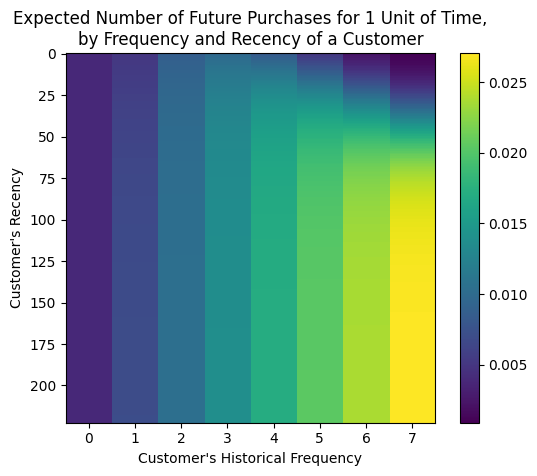

In [120]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

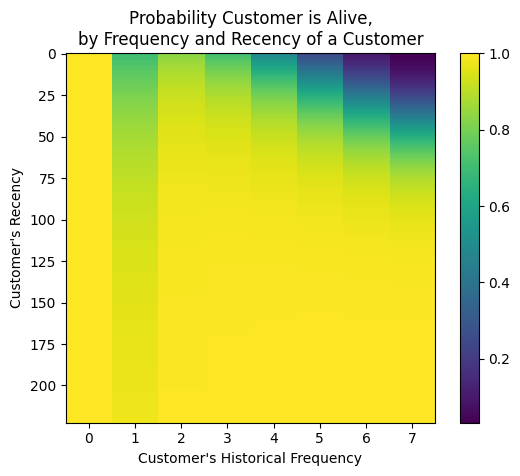

In [121]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

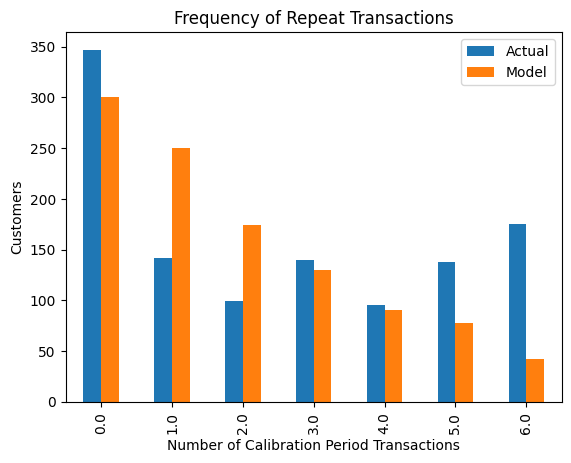

In [127]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf)

In [187]:
calibration_period_end = str(ltv_prediction_df["event_timestamp"].mean().date())

calibration_period_end

'2023-05-16'

In [188]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(
    summary_df,
    "user_id",
    "event_timestamp",
    calibration_period_end=calibration_period_end,
    observation_period_end=observation_period_end,
)

summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
user_id,,,,,
0047993c-3cff-4ab4-a34a-e376f823c282,0.0,0.0,55.0,0.0,151.0
00f7a8b6-9dd5-4806-bc31-69c8bc68bb24,0.0,0.0,29.0,0.0,151.0
0124f243-d4d0-4971-b997-1e6b79c866f0,0.0,0.0,30.0,1.0,151.0
0126e40c-da09-4e28-b687-457716e6ccfd,0.0,0.0,68.0,0.0,151.0
027c73fe-ac43-4ce4-820d-05a927342c7e,1.0,30.0,51.0,0.0,151.0


D:\ProjectsPyCharm\strong_junior_job_search\mobileapp-abtest-ltv\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

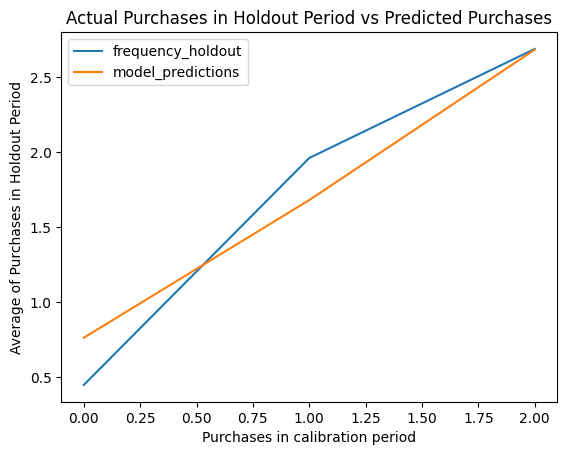

In [189]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(
    summary_cal_holdout["frequency_cal"],
    summary_cal_holdout["recency_cal"],
    summary_cal_holdout["T_cal"],
)
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [195]:
t = 30  # predict purchases in 10 periods
individual = summary_df.iloc[20]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual["frequency"], individual["recency"], individual["T"])
# 0.0576511

0.5207884918895651

In [202]:
summary_df["predicted_revenue"] = summary_df["purchases"] * price

summary_df.describe()

,frequency,recency,T,event_timestamp,revenue,equity,prediction_period,rest,clv,purchases,predicted_revenue
count,1200.000000,1200.000000,1200.000000,1200,1200.000000,1.200000e+03,1200,1200.000000,1200.000000,1200.000000,1200.000000
mean,2.773333,85.975000,193.472500,2023-05-16 22:08:55.034166528,47.128933,3.770900e-01,2024-03-05 04:55:29.999999744,9.614652,47.506023,3.900070,48.711870
min,0.000000,0.000000,160.000000,2023-03-06 04:55:30,12.490000,3.770900e-01,2024-03-05 04:55:30,4.664915,12.867090,1.046410,13.069658
25%,0.000000,0.000000,175.000000,2023-04-05 11:13:16.500000,12.490000,3.770900e-01,2024-03-05 04:55:30,8.541393,12.867090,1.048170,13.091638
50%,3.000000,90.000000,197.000000,2023-05-02 05:23:36.500000,49.960000,3.770900e-01,2024-03-05 04:55:30,10.101840,50.337090,4.120792,51.468696
75%,5.000000,150.000000,211.000000,2023-06-18 15:04:00.249999872,74.940000,3.770900e-01,2024-03-05 04:55:30,10.972405,75.317090,6.203714,77.484390
max,7.000000,210.000000,222.000000,2023-10-14 06:00:06,99.920000,3.770900e-01,2024-03-05 04:55:30,11.990802,100.297090,8.325439,103.984734
std,2.411805,73.112953,19.628176,NaN,30.123443,5.553430e-17,NaN,1.816594,30.123443,2.478678,30.958685


In [207]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

y_actual = summary_df[summary_df["frequency"] < 6]["revenue"]
y_predicted = summary_df[summary_df["frequency"] < 6]["predicted_revenue"]

MSE = mean_squared_error(y_actual, y_predicted)
RMSE = math.sqrt(MSE)

mae = mean_absolute_error(y_actual, y_predicted)

print("MSE: ", MSE, "RMSE: ", RMSE, "mae: ", mae)

MSE:  2.239708365633297 RMSE:  1.4965655233344435 mae:  1.3039996588730403
